In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as K

In [2]:
import sys
sys.path.append('../ptsne-keras')
import parametric_tSNE

In [3]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

def plot_embedding(embedding, y_train, title=""):
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    colors = [plt.cm.tab10.colors[i] for i in y_train]
    ax.scatter(embedding[:,0], embedding[:,1], c=colors, s=2)
    ax.set_aspect(1)
    recs = []
    for i in range(0,10):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
    ax.legend(recs,list(range(10)),loc=2)
    plt.title(title)
    plt.show()

# Datasets & Loaders

In [4]:
import pathlib
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data(
    path='%s/data/mnist.npz'%pathlib.Path().absolute()
)

In [5]:
X_train = mnist_train[0][:,:,:,np.newaxis]
y_train = mnist_train[1]
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [6]:
X_test = mnist_test[0][:,:,:,np.newaxis]
y_test = mnist_test[1]
X_test.shape, y_test.shape

((10000, 28, 28, 1), (10000,))

# Classifier Network

In [7]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as nn

model = Sequential()
model.add(nn.InputLayer(input_shape=(28, 28, 1), name="in"))
model.add(nn.Conv2D(filters=6, kernel_size=5, activation='relu', name="conv1"))
model.add(nn.MaxPool2D(pool_size=2, name="pool1")) # 12x12x6 -> corresponds to conv1 in pytorch
model.add(nn.Conv2D(filters=16, kernel_size=5, activation='relu', name="conv2"))
model.add(nn.MaxPool2D(pool_size=2, name="pool2")) # 4x4x16 -> corresponds to conv2 in pytorch
model.add(nn.Flatten(name="flat")) # 16x4x4
model.add(nn.Dense(120, activation='relu', name="fc1"))
model.add(nn.Dense(100, activation='relu', name="fc2"))
model.add(nn.Dense(10, activation=None, name="fc3"))
model.add(nn.Softmax(name="classifier")) # is needed in keras to properly train on categorical crossentropy loss (in pytorch the crossentropy loss takes logits as inputs)
# print(model.output_shape)

In [8]:
# model.summary()

# Train Initial Network

In [9]:
epochs = 2
tf.random.set_seed(42)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # sgd does not work with this keras model (it works at least a bit, if lr=0.001)
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=['accuracy'],
)

history = model.fit(
    X_train,
    y_train,
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

In [ ]:
model.save('models/mnist-before.h5')

# Embedding

In [10]:
layer_key = 'fc2' # which latent layer output should be used for embedding
# embedding_size = 10 # what's the output size of this layer
#embedding_dim = None#(10) # what is the output dimension

In [11]:
model = tf.keras.models.load_model("models/mnist-before.h5")

In [12]:
model_sub = tf.keras.Model(inputs=model.inputs, outputs=model.get_layer(layer_key).output)
# model_sub.summary()

In [13]:
logits_train = model_sub(X_train)
logits_test = model_sub(X_test)

In [14]:
logits_train.shape

TensorShape([60000, 100])

In [15]:
import importlib
importlib.reload(parametric_tSNE)
import parametric_tSNE

In [16]:
import numpy as np
tf.random.set_seed(42)

embedder = parametric_tSNE.Parametric_tSNE(logits_train.shape[1], num_outputs=2, perplexities=100, optimizer='adam', batch_size=64, do_pretrain=False, all_layers=None, seed=42)
embedding = embedder.fit(logits_train[::100], epochs=1, verbose=1)

(600, 100) (600, 600)
2020-10-13 16:35:09.523073: Beginning training on 1 epochs
(None, 600)
(None, None)
Tensor("KL-Divergence/Sum_2:0", shape=(), dtype=float32)
(None, 600)
(None, None)
Tensor("KL-Divergence/Sum_2:0", shape=(), dtype=float32)


InvalidArgumentError:  Incompatible shapes: [64,600] vs. [64,64]
	 [[node gradient_tape/KL-Divergence/sub_1/BroadcastGradientArgs (defined at ../ptsne-keras\parametric_tSNE\core.py:448) ]] [Op:__inference_train_function_1683]

Function call stack:
train_function


In [18]:
embedder.save('models/mnist-pumap')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/mnist-pumap\encoder\assets
Keras encoder model saved to models/mnist-pumap\encoder
INFO:tensorflow:Assets written to: models/mnist-pumap\parametric_model\assets
Keras full model saved to models/mnist-pumap\parametric_model
Pickle of ParametricUMAP model saved to models/mnist-pumap\model.pkl


In [19]:
projected_train = embedder.encoder(logits_train)
projected_test = embedder.encoder(logits_test)

# Determine Suitable Shifts

In [20]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

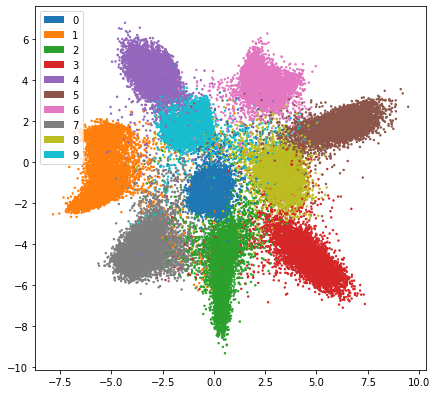

In [80]:
plot_embedding(projected_train[::12], y_train[::12])

In [22]:
labels_train = y_train
shifted_train = projected_train.numpy()

for i in range(10):
    shifted_train[labels_train == i] = (1./2. * shifted_train[(labels_train == i)] + 1./4. * shifted_train[(labels_train == i)].mean(axis=0)) + np.array([0.,0.])

In [23]:
# shifted_train[labels_train == 9] += torch.tensor([7.,7.])
# shifted_train[labels_train == 4] += torch.tensor([-2.,7.])

In [24]:
# labels_train = mnist_train.targets
# shifted_train = projected_train.clone()
# shifted_train[labels_train == 3] = (1./2. * projected_train[(labels_train == 3)] + 1./4. * projected_train[(labels_train == 3)].mean(axis=0)) + torch.tensor([-10.,-7.])
# shifted_train[labels_train == 8] = (3./4. * projected_train[(labels_train == 8)] + 1./4. * projected_train[(labels_train == 8)].mean(axis=0)) + torch.tensor([3.,3.])
# shifted_train[labels_train == 4] = (1./2. * projected_train[(labels_train == 4)] + 1./4. * projected_train[(labels_train == 4)].mean(axis=0)) + torch.tensor([7.,-10.])

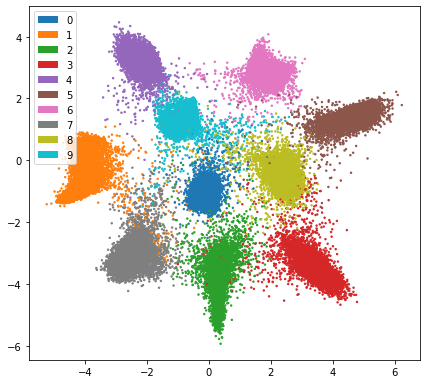

In [81]:
plot_embedding(shifted_train[::12], y_train[::12])

# Retraining

In [27]:
epochs = 4
tf.random.set_seed(42)

In [28]:
model_classifier = tf.keras.models.load_model("models/mnist-before.h5")
embedder = load_ParametricUMAP('models/mnist-pumap')
model_embedder = embedder.encoder

Pickle of ParametricUMAP model loaded from models/mnist-pumap\model.pkl
Keras encoder model loaded from models/mnist-pumap\encoder
Keras full model loaded from models/mnist-pumap\parametric_model


In [29]:
model_embedder = tf.keras.Model(model_embedder.inputs, model_embedder.outputs, name="embedder")
model_embedder.summary()

Model: "embedder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
z (Dense)                    (None, 2)                 202       
Total params: 30,502
Trainable params: 30,502
Non-trainable params: 0
______________________________________________________

In [30]:
# we do not want to train the embedding network!
model_embedder.trainable = False

In [31]:
embedder_out = model_embedder(model_classifier.get_layer(layer_key).output)
model_comb = tf.keras.Model(model_classifier.input, [model_classifier.output, embedder_out])
# model_comb.summary()

In [32]:
# train network using the altered embedded points
model_comb.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # sgd does not work with this keras model (it works at least a bit, if lr=0.001)
    # Loss function to minimize
    loss={"classifier": tf.keras.losses.SparseCategoricalCrossentropy(), "embedder": tf.keras.losses.MeanSquaredError()},
    loss_weights={"classifier": 1.0, "embedder": 1.0},
    # List of metrics to monitor
    metrics=['accuracy'],
)

history = model_comb.fit(
    x=X_train,
    y={"classifier": y_train, "embedder": shifted_train},
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

model_comb.save('models/mnist-after.h5')

Epoch 1/4
1200/1200 [==============================] - 23s 19ms/step - loss: 0.1383 - classifier_loss: 0.0576 - embedder_loss: 0.0808 - classifier_accuracy: 0.9822 - embedder_accuracy: 0.9824
Epoch 2/4
1200/1200 [==============================] - 22s 18ms/step - loss: 0.1121 - classifier_loss: 0.0428 - embedder_loss: 0.0692 - classifier_accuracy: 0.9867 - embedder_accuracy: 0.9859
Epoch 3/4
1200/1200 [==============================] - 22s 18ms/step - loss: 0.0951 - classifier_loss: 0.0341 - embedder_loss: 0.0610 - classifier_accuracy: 0.9891 - embedder_accuracy: 0.9865
Epoch 4/4
1200/1200 [==============================] - 22s 19ms/step - loss: 0.0915 - classifier_loss: 0.0311 - embedder_loss: 0.0604 - classifier_accuracy: 0.9904 - embedder_accuracy: 0.9870


In [33]:
# train network as usual, for better comparability
model_classifier = tf.keras.models.load_model("models/mnist-before.h5")
model_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), #tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # sgd does not work with this keras model (it works at least a bit, if lr=0.001)
    # Loss function to minimize
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=['accuracy'],
)
history = model_classifier.fit(
    x=X_train,
    y= y_train,
    batch_size=50,
    epochs=epochs,
    shuffle=True
)

model_classifier.save('models/mnist-after-baseline.h5')

Epoch 1/4
1200/1200 [==============================] - 22s 19ms/step - loss: 0.0731 - accuracy: 0.9777
Epoch 2/4
1200/1200 [==============================] - 22s 19ms/step - loss: 0.0505 - accuracy: 0.9846
Epoch 3/4
1200/1200 [==============================] - 24s 20ms/step - loss: 0.0436 - accuracy: 0.9871
Epoch 4/4
1200/1200 [==============================] - 23s 19ms/step - loss: 0.0373 - accuracy: 0.9885


#### calculate output for train and test sets over all methods

In [49]:
# outputs for initial model (trained for 5 epochs)
model_classifier = tf.keras.models.load_model("models/mnist-before.h5")
model_sub = tf.keras.Model(inputs=model_classifier.inputs, outputs=model_classifier.get_layer(layer_key).output)
embedder = load_ParametricUMAP('models/mnist-pumap')
model_embedder = embedder.encoder

logits_train_before = model_classifier(X_train)
projected_train_before = model_embedder(model_sub(X_train))
logits_test_before = model_classifier(X_test)
projected_test_before = model_embedder(model_sub(X_test))


Pickle of ParametricUMAP model loaded from models/mnist-pumap\model.pkl
Keras encoder model loaded from models/mnist-pumap\encoder
Keras full model loaded from models/mnist-pumap\parametric_model


In [67]:
# outputs for baseline model (trained for 5 + 4 epochs)
model_classifier = tf.keras.models.load_model("models/mnist-after-baseline.h5")
model_sub = tf.keras.Model(inputs=model_classifier.inputs, outputs=model_classifier.get_layer(layer_key).output)
embedder = load_ParametricUMAP('models/mnist-pumap')
model_embedder = embedder.encoder

logits_train_baseline = model_classifier(X_train)
projected_train_baseline = model_embedder(model_sub(X_train))
logits_test_baseline = model_classifier(X_test)
projected_test_baseline = model_embedder(model_sub(X_test))


Pickle of ParametricUMAP model loaded from models/mnist-pumap\model.pkl
Keras encoder model loaded from models/mnist-pumap\encoder
Keras full model loaded from models/mnist-pumap\parametric_model


In [51]:
# outputs for model using latent interventions (trained for 5 + 4 epochs)
model_combined = tf.keras.models.load_model("models/mnist-after.h5")

logits_train_after, projected_train_after = model_combined(X_train)
logits_test_after, projected_test_after = model_combined(X_test)


# Evaluation

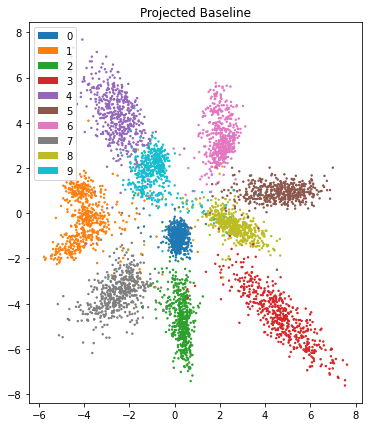

In [52]:
plot_embedding(projected_train_baseline[::12], y_train[::12], "Projected Baseline")

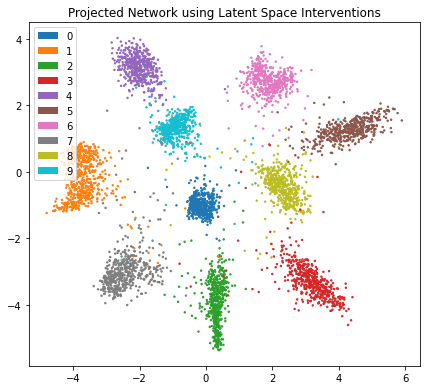

In [53]:
plot_embedding(projected_train_after[::12], y_train[::12], "Projected Network using Latent Space Interventions")

In [68]:
def get_cf(y, logits):
    cf = np.zeros((10,10), dtype="int64")
    for i in zip(y, logits.numpy().argmax(1)):
        cf[i] += 1
    return cf

In [69]:
cf_train_before = get_cf(y_train, logits_train_before)

cf_test_before = get_cf(y_test, logits_test_before)

In [70]:
cf_train_baseline = get_cf(y_train, logits_train_baseline)

cf_test_baseline = get_cf(y_test, logits_test_baseline)

In [71]:
cf_train_altered = get_cf(y_train, logits_train_after)

cf_test_altered = get_cf(y_test, logits_test_after)

In [72]:
# baseline accuracy
np.diag(cf_test_baseline).sum() / cf_test_baseline.sum()

0.9859

In [73]:
# intervention accuracy
np.diag(cf_test_altered).sum() / cf_test_altered.sum()

0.9863

In [74]:
cf_test_before

array([[ 957,    2,    2,    2,    1,    2,    7,    2,    0,    5],
       [   0, 1101,    1,    6,    3,    3,    2,    4,   14,    1],
       [   2,    0,  963,   43,    1,    2,    2,   10,    9,    0],
       [   0,    0,    0,  996,    0,    8,    0,    2,    3,    1],
       [   0,    0,    0,    0,  962,    0,    4,    0,    3,   13],
       [   0,    0,    0,    5,    0,  882,    1,    1,    2,    1],
       [   0,    1,    0,    0,    5,   11,  939,    0,    1,    1],
       [   1,    1,    3,    5,    0,    2,    0, 1007,    3,    6],
       [   2,    0,    2,    4,    4,    4,    0,    1,  956,    1],
       [   2,    1,    0,   12,    5,    6,    0,    3,   13,  967]],
      dtype=int64)

In [75]:
cf_test_baseline

array([[ 976,    0,    1,    0,    0,    0,    2,    1,    0,    0],
       [   1, 1121,    1,    6,    4,    0,    2,    0,    0,    0],
       [   0,    2, 1022,    1,    0,    0,    0,    7,    0,    0],
       [   0,    0,    1, 1000,    0,    7,    0,    0,    2,    0],
       [   0,    0,    0,    0,  978,    0,    1,    1,    0,    2],
       [   1,    0,    0,   10,    0,  878,    1,    0,    2,    0],
       [   6,    4,    0,    1,    3,    2,  940,    0,    2,    0],
       [   0,    4,    3,    5,    2,    0,    0, 1008,    0,    6],
       [   3,    0,    3,    3,    5,    1,    1,    1,  950,    7],
       [   0,    1,    0,    3,    8,    6,    0,    1,    4,  986]],
      dtype=int64)

In [76]:
cf_test_altered

array([[ 975,    2,    2,    0,    0,    0,    0,    1,    0,    0],
       [   0, 1127,    1,    4,    0,    0,    2,    1,    0,    0],
       [   1,    1, 1023,    0,    1,    0,    0,    3,    3,    0],
       [   0,    0,    4,  995,    0,    5,    0,    2,    4,    0],
       [   0,    0,    1,    0,  974,    0,    2,    0,    1,    4],
       [   2,    0,    0,    9,    0,  878,    1,    1,    1,    0],
       [   6,    2,    2,    0,    3,    1,  942,    0,    2,    0],
       [   1,    5,    5,    0,    0,    1,    0, 1007,    1,    8],
       [   2,    2,    4,    0,    3,    2,    0,    3,  954,    4],
       [   1,    1,    0,    2,    8,    4,    0,    1,    4,  988]],
      dtype=int64)

In [77]:
def prec(cf, l):
    return cf[l,l] / cf[:,l].sum()
def rec(cf, l):
    return cf[l,l] / cf[l,:].sum()
def f1(cf, l):
    return 2 * prec(cf, l) * rec(cf, l) / (prec(cf, l) + rec(cf, l))

In [78]:
# print(prec(cf_test_baseline, 3))
# print(rec(cf_test_baseline, 3))
# print(f1(cf_test_baseline, 3))

# print(prec(cf_test_baseline, 8))
# print(rec(cf_test_baseline, 8))
# print(f1(cf_test_baseline, 8))

print(f1(cf_test_baseline, 4))
print(f1(cf_test_baseline, 9))

0.9868819374369324
0.9810945273631839


In [79]:
# print(prec(cf_test_altered, 3))
# print(rec(cf_test_altered, 3))
# print(f1(cf_test_altered, 3))

# print(prec(cf_test_altered, 8))
# print(rec(cf_test_altered, 8))
# print(f1(cf_test_altered, 8))

print(f1(cf_test_altered, 4))
print(f1(cf_test_altered, 9))

0.9883307965499746
0.9816194734227521
